# Example 2: Capturing patterns between features (PrivBayes)
In this notebook we will explore a more sophisticated algorithm that aims to capture patterns between features.

# Environment

## Library Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Jupyter-specific Imports and Settings

In [2]:
# set printing options
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')

get_ipython().run_line_magic('autoreload', '2')
from importlib import reload

## Import Synthesizer
For this example we will use the PrivBayes algorithm (Zhang et al, 2017). PrivBayes approximates the original data through a private Bayesian network with noisy conditional distributions. This network is a direct-acyclic graph (DAG), as such, for each record the algorithm samples a column value node by node while conditioning for the parent's nodes.

One caveat of algorithms that try to capture patterns between features, like PrivBayes, is that they are computationally expensive. Hence, for optimal performance we focus on categorical data with a low number of columns and column cardinalities.

In [3]:
from synthesis.synthesizers.privbayes import PrivBayes

# Synthetic Data Generation
Let's load a dataset to see how the generation process works.

In this example we will use the adult dataset - source: https://archive.ics.uci.edu/ml/datasets/adult

In [4]:
df = pd.read_csv('../data/original/adult.csv', delimiter=', ', engine='python')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Unfortunately the algorithm PrivBayes does not support continuous data very well, as the conditional probability tables can become very large. We can either discretize continuous variables or remove them from the data. For sake of simplicity we choose to remove them.

In [5]:
print('column - unique values\n')
for c in df.columns:
    print("{} - {}".format(c, df[c].nunique()))

column - unique values

age - 73
workclass - 9
fnlwgt - 21648
education - 16
education-num - 16
marital-status - 7
occupation - 15
relationship - 6
race - 5
sex - 2
capital-gain - 119
capital-loss - 92
hours-per-week - 94
native-country - 42
income - 2


In [6]:
df = df.drop(columns=['fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week', 'age', 'native-country'])

We will now import our synthesizer and fit it on the input data. 

We can define a large of range of parameters, but for now we only define the epsilon value and set the remaining parameters to their default value.
- espilon: quantifies the privacy risk posed by releasing statistics computed on sensitive data (i.e. differential privacy). More on that here: https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf

In [7]:
epsilon = 0.1

pb = PrivBayes(epsilon=epsilon)
pb.fit(df)

Degree of network (k): 4

1/9 - Root of network: marital-status

2/9 - Evaluating next node to add to network
Number of NodeParentPair candidates: 8
Selected node: workclass - with parents: ('marital-status',)

3/9 - Evaluating next node to add to network
Number of NodeParentPair candidates: 7
Selected node: race - with parents: ('workclass', 'marital-status')

4/9 - Evaluating next node to add to network
Number of NodeParentPair candidates: 6
Selected node: education - with parents: ('workclass', 'race', 'marital-status')

5/9 - Evaluating next node to add to network
Number of NodeParentPair candidates: 5
Selected node: sex - with parents: ('workclass', 'race', 'education', 'marital-status')

6/9 - Evaluating next node to add to network
Number of NodeParentPair candidates: 20
Selected node: income - with parents: ('workclass', 'education', 'marital-status', 'race')

7/9 - Evaluating next node to add to network
Number of NodeParentPair candidates: 45
Selected node: education-num - with

After fitting the Bayesian Network on the data, we can now sample from it using the following method.

In [8]:
df_synth = pb.sample()

Number of records generated: 32561 / 32561
Synthetic Data Generated



In [9]:
df_synth.head(3)

,workclass,education,education-num,marital-status,occupation,relationship,race,sex,income
0,Never-worked,9th,3,Never-married,Priv-house-serv,Husband,White,Female,<=50K
1,?,Assoc-voc,7,Divorced,Transport-moving,Wife,Amer-Indian-Eskimo,Female,<=50K
2,?,9th,1,Married-AF-spouse,Prof-specialty,Husband,White,Male,<=50K


# Utility Evaluation
NOTE: this section will be extended in the near future.

In order to evaluate the output we can examine the feature distances for each attribute, i.e. we compares the value counts for each column in the original with the synthetic dataset.

In [10]:
from synthesis.evaluation import visual

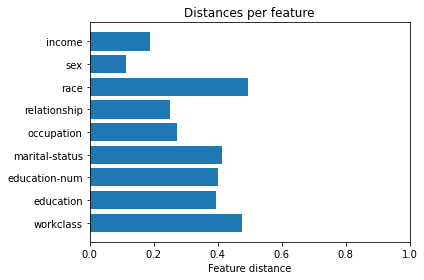

In [11]:
visual.plot_feature_distances(df, df_synth)

Notice that for each feature independently the synthetic data has quite a large distance to the original data. In the future we would like to evaluate if relations between features are preserved.